In [1]:
import numpy as np
import pandas as pd 
from typing import List
from typing import Tuple
from functools import reduce

import matplotlib.pyplot as plt

import unittest

import os
import warnings
warnings.filterwarnings("ignore")

## 1.Описание задачи


Задача состоит в выделение именованных сущностей из текста. Именованные сущности это некоторые непрерывные фрагменты текста(чаще всего из 1-2 слов), которые надо отнести к одной из заранее выделеных категорий. 

Классические подход - разбить текст на токены, получить их обмеддинги и обучить классификатор. Базовые модели: word2vec/tf-idf + классификатор, RNN - LSTM.  Сейчас стандартным подходом является модель Bert. Bert - энкодер трансформера, с помощью механизма внимания позволяет улавливать контекст, что важно при нахождение именованных сущностей. Также существуют множество предобученных Bert моделей, которые можно дообучить на выборке небольшой размерности. 

Для LLM можно написать промт для выделения сущностей. Можно также дообучить llm на своих данных. В данный момент применение LLM для задач NER не так распространено(особенно в проде).

Оценивать можно по метрикам классификации, стандарт - f1_score.

## 2. Чтение данных

In [2]:
annotated_ru_path = '/kaggle/input/sample/sample_pl_cs_ru_bg/annotated/ru'
raw_ru_path = '/kaggle/input/sample/sample_pl_cs_ru_bg/raw/ru'

Ответы будем хранить в виде словаря. Это даст возможность удобно оценивать работу алгоритма. В дальнейшем можно расширить характеристики овтета - добавить начальную форму и именованную сущность на английском.

In [3]:
samples = {'document_id' : [], 'document_text' : [], 'entity' : [], 'gold_answer' : []} 

for file_name in os.listdir(raw_ru_path):
    with open(os.path.join(raw_ru_path, file_name), "r", encoding="utf-8") as file:
        text = []
        for i, line in enumerate(file):
            if i == 0:
                index = line.strip()
            if i > 5:
                text.append(line.strip())
        samples['document_id'].append(index) 
        samples['document_text'].append(''.join(text))
        
for file_name in os.listdir(annotated_ru_path):
    with open(os.path.join(annotated_ru_path, file_name), "r", encoding="utf-8") as file:
        entity = []
        gold_answer = {}
        for i, line in enumerate(file):
            if i == 0:
                index = line.strip()
            else:
                current_line = line.strip().split()
                gold_entity = ' '.join(current_line[(len(current_line) - 2) // 2 : -2])
                if current_line[-2] in gold_answer:
                    gold_answer[current_line[-2]].append(gold_entity)
                else:
                    gold_answer[current_line[-2]] = [gold_entity]
                entity.append(current_line[-2])
        samples['entity'].append(list(set(entity)))
        samples['gold_answer'].append(gold_answer)   
data = pd.DataFrame(samples)

In [4]:
data.head()

,document_id,document_text,entity,gold_answer
0,ru-1003,Об этом сообщает агентство Рейтер. Сегодня пре...,"[LOC, ORG, PRO, EVT, PER]","{'EVT': ['Brexit'], 'PRO': ['The Guardian'], '..."
1,ru-1017,КИЕВ. 9 июля. УНН. Борис Джонсон подал в отста...,"[EVT, PER, ORG, LOC]","{'EVT': ['Brexit'], 'PER': ['Джонсон', 'Джонсо..."
2,ru-1011,Комментируя отставку министра иностранных дел ...,"[EVT, PER, ORG, LOC]","{'ORG': ['Press', 'ЕС', 'Евросоюз', 'Евросоюза..."
3,ru-1006,Официальный представитель МИД России Мария Зах...,"[LOC, ORG, PRO, EVT, PER]","{'EVT': ['Brexit'], 'PRO': ['The Guardian'], '..."
4,ru-10,"Тем не менее, по сведениям британских СМИ, на ...","[LOC, ORG, PRO, EVT, PER]","{'EVT': ['Brexit'], 'PRO': ['Facebook'], 'PER'..."


In [5]:
data['gold_answer'][0]

{'EVT': ['Brexit'],
 'PRO': ['The Guardian'],
 'PER': ['Борис Джонсон',
  'Борис Джонсон',
  'Борис Джонсон',
  'Джонсон',
  'Джонсон',
  'Дэвид Дэвис',
  'Дэвис',
  'Мэй',
  'Тереза Мэй',
  'Тереза Мэй',
  'Тереза Мэй'],
 'LOC': ['Великобритания', 'Великобритания'],
 'ORG': ['ЕС', 'Евросоюз', 'Палата общин']}

## 3. Промт для LLM

In [6]:
def promt(sample):
    entiny = ['ORG' ,'PRO', 'EVT', 'LOC', 'PER']
    prom = 'Из текста ниже получи именованные сущности относящиеся к одной из 5 категорий: 1)ORG(Любые организации - союзы, организации, министерства и компании), 2) категория PRO(product - название газеты и компаний),3)EVT(Events - любые События - собрания ), 4) категория локаций LOC(все страны, союзы, государства или города), ' + \
    '5)PER(persons, ФИ персоны)' + \
    "Вернуть все в строгом формате словаря: {" + ''.join(["'" + ent + "' : [массив из ВСЕХ! сущностей], " for ent in entiny])  + \
    'Вот и сам текст новостей' + sample['document_text']

    return prom

## 4. Ответы  GigaChat

Все ответы получены автоматически через api и сохранены в csv файл.

In [7]:
!pip install gigachat;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.3 MB/s eta 0:00:00


In [8]:
from gigachat import GigaChat

In [9]:
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload='scope=GIGACHAT_API_PERS'
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': 'CS', #здесь был ключ CS
  'Authorization': 'Basic auto' # вместо auto ключ авторизации
}
try: 
    response = requests.post(url, headers=headers, data=payload, verify=False)
except requests.RequestException as e:
    print(f"Ошибка: {str(e)}")
    
giga_token = response.json()['access_token']

In [10]:
import requests
import json

def get_chat(auth_token, user_message):
    url = "https://gigachat.devices.sberbank.ru/api/v1/chat/completions"

    payload = json.dumps({
        "model": "GigaChat", 
        "messages": [
            {
                "role": "user",
                "content": user_message  
            }
        ],
        "n": 1, 
        "stream": False, 
        "max_tokens": 512, 
        "update_interval": 0  
    })

    headers = {
        'Content-Type': 'application/json', 
        'Accept': 'application/json',  
        'Authorization': f'Bearer {auth_token}' 
    }

    try:
        response = requests.request("POST", url, headers=headers, data=payload, verify=False)
        return response
    except requests.RequestException as e:
        print(f"Произошла ошибка: {str(e)}")
        return -1

In [11]:
predictions = []

for i in range(len(data)):
    answer = get_chat(giga_token, promt(data.iloc[i]))
    try:
        predictions.append(eval(answer.json()['choices'][0]['message']['content']))
    except:
        predictions.append({'ORG': [], 'PRO': [],'EVT': [], 'LOC': [],'PER':[]})

In [12]:
data.insert(4, "Predictions", predictions, True)

In [13]:
data['Predictions'][0]

{'ORG': ['Даунинг-Стрит'],
 'PRO': [],
 'EVT': [],
 'LOC': [],
 'PER': ['Тереза Мэй', 'Борис Джонсон', 'Дэвид Дэвис']}

In [14]:
data['gold_answer'][0]

{'EVT': ['Brexit'],
 'PRO': ['The Guardian'],
 'PER': ['Борис Джонсон',
  'Борис Джонсон',
  'Борис Джонсон',
  'Джонсон',
  'Джонсон',
  'Дэвид Дэвис',
  'Дэвис',
  'Мэй',
  'Тереза Мэй',
  'Тереза Мэй',
  'Тереза Мэй'],
 'LOC': ['Великобритания', 'Великобритания'],
 'ORG': ['ЕС', 'Евросоюз', 'Палата общин']}

## 5. Подсчет метрики score_fn

Выбрал метрику f1 c макро усреднением. Это поможет учитывать не очень популярные категории, например, PRO на фоне PER.
Это важно в нашей задаче, т.к. модель не должна иметь смещение в сторону одной наиболее популярной категории.

In [15]:
def precision_recall(gold_list: List[str], pred_list: List[str])->Tuple[float, float]:
    precision = 0.0
    recall = 0.0
    tp = len(list((set(gold_list) & set(pred_list))))
    fp = len(list((set(pred_list) - set(gold_list))))
    fn = len(list((set(gold_list) - set(pred_list))))
    if tp + fn != 0: 
        recall = tp / (tp + fn)
    if tp + fp != 0:
        precision = tp / (tp + fp)
    
    return precision, recall

Проблема применения векторизации - модель может выдавать сущности в любом порядке. Тогда их придеться сортировать по ключу(а потом все равно искать пересечения множеств)

In [16]:
def score_fn_macro(gold: dict, pred: dict)->float:
    """
    Считаем precision и recall c помощью макроусреднения
    Это поможет нам учесть предсказания модели на классах с маленькой выборкой.
    Стандартно считаем f1 по полученным precision и recall.
    """
    
    precision = 0.0
    recall = 0.0

    for entity in pred:
        if entity in gold:
            pre, re = precision_recall(gold[entity], pred[entity])
            precision += pre
            recall += re
        
    precision = precision / len(pred)
    recall = recall / len(pred)

    if precision + recall == 0.0:
        return 0.0
    return 2*(precision * recall / (precision + recall))

In [17]:
class TestPrecisionRecall(unittest.TestCase):
    def test_precision_recall(self):
        self.assertEqual(precision_recall(["a", "b", "c"], ["a", "b", "d"]), (2/3, 2/3))
        self.assertEqual(precision_recall([], ["a", "b", "c"]), (0.0, 0.0))
        self.assertEqual(precision_recall(["a", "b", "c"], []), (0.0, 0.0))
        self.assertEqual(precision_recall(["a", "b", "c"], ["a", "b", "c", "d"]), (3/4, 1.0))
        self.assertEqual(precision_recall(["a", "b", "c", "d"], ["a", "b", "c"]), (1.0, 3/4))

class TestScoreFnMacro(unittest.TestCase):
    def test_score_fn_macro(self):
        gold = {
            "entity1": ["a", "b", "c"],
            "entity2": ["d", "e"]
        }
        pred = {
            "entity1": ["a", "b", "c"],
            "entity2": ["d", "e"]
        }
        self.assertAlmostEqual(score_fn_macro(gold, pred), 1.0, places=6)
        
        gold = {
            "entity1": ["a", "b"],
            "entity2": ["d", "e"]
        }
        pred = {
            "entity1": ["a", "c"],
            "entity2": ["d", "e"]
        }
        self.assertAlmostEqual(score_fn_macro(gold, pred), 0.75, places=6)
        
        gold = {
            "entity1": ["a", "b", "c"],
            "entity2": ["d", "e"],
            "entity3": ["f", "g"]
        }
        pred = {
            "entity1": ["a", "b"],
            "entity2": ["d", "f"],
            "entity3": ["g", "h"]
        }
        self.assertAlmostEqual(score_fn_macro(gold, pred), 0.6060606, places=6)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


## 6. Вычисление метрики для каждой строки в датафрейме

Считаем f1 по всем документам

In [18]:
f1_macro = {'document_id':[], 'macro_f1' : [ ]}
for i in range(len(data)):
    f1_macro['macro_f1'].append(score_fn_macro(data['gold_answer'][i], data['Predictions'][i]))
    f1_macro['document_id'].append(data['document_id'][i])

Агрегация метрик

In [19]:
score_entity = {'ORG_f1': [], 'LOC_f1': [],'EVT_f1': [], 'PER_f1': [],'PRO_f1':[]}
for entity in score_entity:
    for i in range(len(data)):
        precision, recall = 0, 0
        if entity[:-3] in data['gold_answer'][i]:
            precision, recall = precision_recall(data['gold_answer'][i][entity[:-3]], data['Predictions'][i][entity[:-3]])
        f1 = 0
        if precision + recall != 0:
            f1 = 2*(precision * recall / (precision + recall))
        score_entity[entity].append(f1)

In [20]:
metrics = pd.DataFrame(f1_macro | score_entity)

In [21]:
metrics

,document_id,macro_f1,ORG_f1,LOC_f1,EVT_f1,PER_f1,PRO_f1
0,ru-1003,0.133333,0.000000,0.000000,0,0.666667,0.0
1,ru-1017,0.000000,0.000000,0.000000,0,0.000000,0.0
2,ru-1011,0.203226,0.000000,0.500000,0,0.500000,0.0
3,ru-1006,0.044444,0.000000,0.000000,0,0.222222,0.0
4,ru-10,0.141176,0.000000,0.333333,0,0.250000,0.0
5,ru-1002,0.070774,0.153846,0.000000,0,0.200000,0.0
6,ru-1004,0.133333,0.000000,0.000000,0,0.666667,0.0
7,ru-1000,0.240000,0.000000,0.000000,0,0.666667,0.5
8,ru-1001,0.114286,0.000000,0.000000,0,0.571429,0.0


In [22]:
data['gold_answer'][7], data['Predictions'][7]

({'EVT': ['Brexit'],
  'PRO': ['The Guardian', 'Подробности.ua'],
  'PER': ['Борис Джонсон',
   'Борис Джонсон',
   'Бориса',
   'Джонсон',
   'Дэвид Дэвис',
   'Стив Бейкер',
   'Тереза Мэй'],
  'LOC': ['Великобритания'],
  'ORG': ['ЕС', 'МИД Соединенного Королевства', 'УНН']},
 {'ORG': ['Британский парламент',
   'Премьер-министр Великобритании',
   'Министерство по вопросам выхода Великобритании из ЕС',
   'Заместитель министра по Brexit'],
  'PRO': ['The Guardian', 'УНН'],
  'EVT': [],
  'LOC': [],
  'PER': ['Дэвид Дэвис', 'Стив Бейкер', 'Борис Джонсон']})

Модель выявило всех персон, хотя и не учла их повторения.

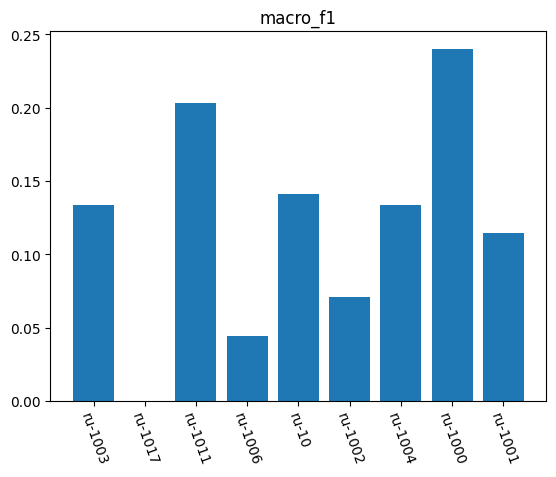

In [23]:
plt.bar(metrics['document_id'], metrics['macro_f1']);
plt.title('macro_f1');
plt.xticks(rotation=-70);

## 7. Зависимость метрик от длины документа

Явной зависимости нет

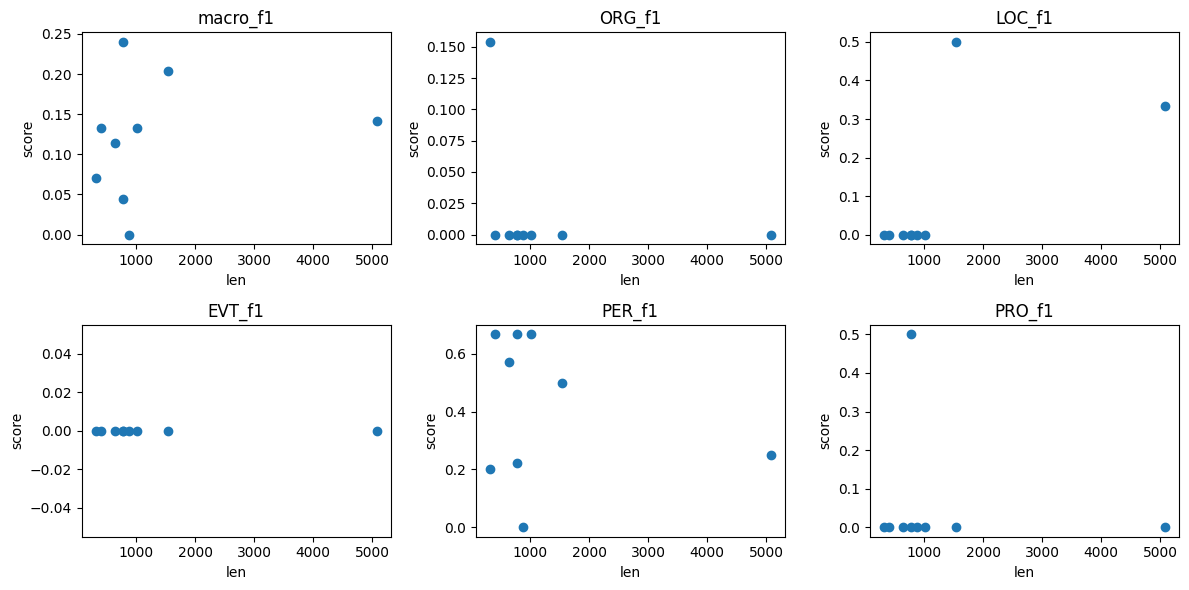

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten() 

doc_len = list(map(len, data['document_text']))
for (i, columns) in enumerate(metrics.columns[1:]):
    axes[i].scatter(doc_len, metrics[columns])
    axes[i].set_title(columns)
    axes[i].set_xlabel("len")
    axes[i].set_ylabel("score")

plt.tight_layout()
plt.show()

## 8. Анализ ошибок

Модель неплохо справляется с именами людей(PER). Можно попробовать стандартизировать запрос по каждой сущности. Разбивать на подзапросы.

## 9. Выводы

Было интересно попробовать llm в необычной для нее задачи. В будущем стоит продолжить экспериментировать с промтом, например, попробовать разбить текст на несколько кусков и задавать более конкретный запрос.
   
Результаты показывают, что сырая модель пока не справляется с выявлением сущностей и скорее подойдет в качестве разметичка  данных.

In [25]:
data.to_csv('pred.csv')

[](http://)